# Getting data into and out of Neuroglancer

As part of data analysis, we often need to use neuroglancer to help annotate or provide context for data analysis.

Here, we describe the datasets available on [Microns Explorer](https://microns-explorer.org/), explain how to get information out of neuroglancer states, and put the results of some analysis back into neuroglancer.

We are only going to use some basic 

In [1]:
import pandas as pd
import numpy as np
from nglui import statebuilder

## 1. Data on Microns Explorer

Several useful data tables are available Under the Data -> Layer 2/3 page of Microns Explorer, which you can [go directly to here](https://microns-explorer.org/phase1).
Due to the nature of connectomics data, the so-called "Phase 1" dataset underwent considerable proofreading and our data tables were updated along the way.
As we were proofreading, we would update our data tables.
The data release "v185" refers to the final state of proofreading before moving on to other tasks.
At the v185 stage, all neurons with cell bodies in the volume had been extensively proofread, as well as Chandelier cell axons.

In our work, we generally use [Pandas](https://pandas.pydata.org/) dataframes for organizing our data.
If you aren't familiar with Pandas, there is [extensive documentation here](https://pandas.pydata.org/docs/user_guide/index.html).
In short, dataframes are a data representation where each row is a data point and each column is one property of the data.

### Soma/Cell Type Table

It is important to know what cells you are working with.
The soma table has basic information about the location and basic cell type (Excitory, Inhibitory, or Glia) of all cells with soma in the volume.
This can be used to look up specific neurons by cell type or provide relative location of positions in the dataset to a cell body.

In [6]:
soma_table_file = 'data/soma_valence_v185.csv'
soma_df = pd.read_csv(soma_table_file)

In [7]:
soma_df.head()

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm
0,17,e,[103860 44385 891],648518346349540057,415440,415440,4154400
1,453,e,[84054 50604 1424],648518346349538466,336216,336216,3362160
2,35,e,[103728 54333 304],648518346349538711,414912,414912,4149120
3,74,e,[51543 57568 155],648518346349538715,206172,206172,2061720
4,231,e,[77197 61773 428],648518346349537038,308788,308788,3087880


Each row describes a different cell.
Let's look at each column:

**Row and cell type**
* `id`: Unique annotation id for the synapse
* `cell_type`: Valence of each cell: `e` for excitatory, `i` for inhibitory, `g` for glia.
* `pt_root_id`: Unique id for the cell.

**Location in nanometer coordinates**
* `soma_x_nm`, `soma_y_nm`, `soma_z_nm`: The x/y/z location of the center of the cell body in nanometer coordinates. Note that neuroglancer uses voxels, not nanometers.

**Location in voxel coordinates**
* `pt_position`: A 3-element location of the presynaptic site in voxel coordinates. Note that loaded this way, this is imported as a string.

---

For convenience, let's turn the `pt_position` string into a numeric list with some simple python

In [8]:
soma_df

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm
0,17,e,[103860 44385 891],648518346349540057,415440,415440,4154400
1,453,e,[84054 50604 1424],648518346349538466,336216,336216,3362160
2,35,e,[103728 54333 304],648518346349538711,414912,414912,4149120
3,74,e,[51543 57568 155],648518346349538715,206172,206172,2061720
4,231,e,[77197 61773 428],648518346349537038,308788,308788,3087880
...,...,...,...,...,...,...,...
451,298,e,[116314 58234 933],648518346349537961,465256,465256,4652560
452,444,e,[70253 54531 1752],648518346349538336,281012,281012,2810120
453,69,e,[75256 56402 571],648518346349537509,301024,301024,3010240
454,116,e,[77180 55980 185],648518346349537641,308720,308720,3087200


In [9]:
# Convert pt_position strings to a list:

def position_string_to_array(pos_string):
    vals = pos_string[1:-1].split(' ')
    return [int(x) for x in vals if len(x) > 0]

# "apply" will apply this function to every element of the column
soma_df['pt_position'] = soma_df['pt_position'].apply(position_string_to_array)

---
#### How do these values relate to what you see in Neuroglancer?

Let's look at a random row from the data perspective and in neuroglancer.
To open a new Neuroglancer window, go to http://layer23.microns-explorer.org.

First, copy the coordinate in pt_position and paste it into the location field in the upper left of the neuroglancer window.

In [10]:
soma_df.loc[[10]]

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm
10,111,e,"[77857, 63138, 1702]",648518346349539095,311428,311428,3114280


This will put you right in the middle of the nucleus.
If you double click it, you'll find that, as expected from the `cell_type` being `e`, this is a pyramidal cell as evident from the dendritic spines.
Moreover, if you look at the object id on the "rendering" tab on the right, this will match the value in `pt_root_id`.

Consistent root ids across data tables and neuroglancer let us keep track of cells.

### Synapse Table

The biggest data table is the synapse table (388 MB), which has a row for each of the 3.2 million synapses in the data set.
It is too large to be hosted by github, so please download from [here](https://zenodo.org/record/3710459/files/pni_synapses_v185.csv?download=1) and place the file `pni_synapses_v185.csv` in the `data/` directory in this notebook folder.
Here, we explain what is in this data file.


Here, each row is a synapse detected by the machine learning method described in [Turner et al. 2019](https://arxiv.org/abs/1904.09947).
The data in this table has approximately 90% precision and 90% recall, but has not been explicitly proofread.
As with any output of a machine learning pipeline, this means there are some false positives and false negatives in the data.
If you run across something very surprising, it's always valuable to double check the raw data.

In [11]:
# Load the synapse table into pandas
synapse_table_file = 'data/pni_synapses_v185.csv'
synapse_df = pd.read_csv(synapse_table_file)
synapse_df.head()

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335


Each row describes the a different aspect of the synapse.
Let's look at each column:

**Annotation and connectivity**
* `id`: Unique annotation id for the synapse
* `pre_root_id`: Object id of the presynaptic neuron
* `post_root_id`: Object id of the postsynaptic neuron

**Synapse size**
* `cleft_vx`: Size of the synaptic cleft in total voxel count. Generally proportional to surface area.

**Location in nanometer coordinates**
* `ctr_pt_x_nm`, `ctr_pt_y_nm`, `ctr_pt_z_nm`: The x/y/z location of the synaptic cleft in nanometer coordinates. Note that neuroglancer uses voxels, not nanometers.

**Location in voxel coordinates**
* `pre_pt_x_vx`, `pre_pt_y_vx`, `pre_pt_z_vx`: The x/y/z location of the presynaptic site in voxel coordinates.
* `ctr_pt_x_vx`, `ctr_pt_y_vx`, `ctr_pt_z_vx`: The x/y/z location of the synaptic cleft in voxel coordinates.
* `post_pt_x_vx`, `post_pt_y_vx`, `post_pt_z_vx`: The x/y/z location of the postsynaptic site in voxel coordinates.

---
#### How do these values relate to what you see in Neuroglancer?

Go to http://layer23.microns-explorer.org.

Let's bring up one synaptic input onto the cell we looked up before.
We do this by selecting all synapses whose `post_root_id` is the root id in question.

In [12]:
# Cell id copied from above
root_id = 648518346349539095

# Pandas has a handy `query` function that makes selecting data particularly easy
synapse_df.query('post_root_id == @root_id' )

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
68267,1335150,648518346349537083,648518346349539095,452,277952,177832,82480,69442,44482,2060,69488,44458,2062,69434,44452,2061
79068,167778,648518346344276596,648518346349539095,75,171712,235280,76680,42950,58848,1916,42928,58820,1917,42902,58786,1916
99383,1115123,648518346349537956,648518346349539095,169,337456,260272,21560,84366,65104,537,84364,65068,539,84362,65034,538
99680,3196476,648518346349538048,648518346349539095,240,268260,218308,63120,67006,54574,1580,67065,54577,1578,67074,54558,1581
99956,3301344,648518346349538194,648518346349539095,193,410652,254532,71560,102634,63610,1788,102663,63633,1789,102632,63698,1788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233412,671979,648518346342920657,648518346349539095,121,398024,261720,68360,99546,65434,1711,99506,65430,1709,99472,65410,1710
3233413,671938,648518346342921597,648518346349539095,150,318428,195288,53640,79630,48842,1339,79607,48822,1341,79574,48806,1340
3233414,662254,648518346341932602,648518346349539095,120,257624,296264,61520,64422,74010,1537,64406,74066,1538,64418,74102,1537
3233415,631097,648518346349386793,648518346349539095,240,443288,252028,72560,110752,63016,1813,110822,63007,1814,110848,62992,1811


Let's go to the location for one of the synapses.
For simplicity's sake, let's focus on one random row.
First, let's look at the center points.
Copy the values from `ctr_pos_x_vx` to `ctr_pos_z_vx` for one of the rows and paste it into neuroglancer.
If you click the segmentation on the other side of the synapse, it has an id that matches the `pre_root_id` value.
Try again with the `pre_pos_x/y/z_vx` and `post_pos_x/y/z_vx` and you'll see that they go to points within the segmentation on either side.

In [13]:
synapse_df.query('post_root_id == @root_id' ).iloc[[1320]]

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
2900469,2597992,648518346341886906,648518346349539095,806,240248,279264,59360,59990,69806,1483,60062,69816,1484,60072,69774,1483


### Proofread Soma Subgraph Synapses

This is a subset of the synapse table that is only synapses between excitatory neurons with cells in the volume.
This has only 1962 synapses, but all of them have been manually inspected and have a spine head volume associated with them.
From a data standpoint, it is similar to the synapse table.

### Making your own annotations in neuroglancer

You can use "export csv" button in the annotation tab to save manual annotations to your computer.
By default, annotations just have points associated with them.
If you want to also get the root id of the objects that you click on, after you create an annotation layer go to the top of its panel and set "Linked Segmentation" to the name of the segmentation layer.

Note that not every annotation uses every column.
Some annotations like lines or bounding boxes have multiple points associated with them, and an ellipsoid annotation has a three radius dimensions.

In [14]:
annotation_filename = 'data/annotations_spines.csv'
manual_df = pd.read_csv(annotation_filename)

manual_df.head()

,Coordinate 1,Coordinate 2,Ellipsoid Dimensions,Tags,Description,Segment IDs,Parent ID,Type,ID
0,"(80369, 57223, 1802)",NaN,NaN,NaN,NaN,648518346349539095,NaN,Point,NaN
1,"(81314, 57382, 1823)",NaN,NaN,NaN,NaN,648518346349539095,NaN,Point,NaN
2,"(82030, 56747, 2018)",NaN,NaN,NaN,NaN,648518346349539095,NaN,Point,NaN
3,"(81962, 56693, 1990)",NaN,NaN,NaN,NaN,648518346349539095,NaN,Point,NaN
4,"(81834, 57115, 1865)",NaN,NaN,NaN,NaN,648518346349539095,NaN,Point,NaN


---
## Manipulating data and viewing it in Neuroglancer

Visualizing data in python using packages like matplotlib, seaborn, and plotly is fantastic and well-documented.
However, one useful thing is to visualize spatial data in neuroglancer itself, which lets us quickly look at the context of data points in terms of imagery, morphology, and all of the rest of the data we can explore there.

Let's start by digging into inhibitory neurons a bit.

In [15]:
# First, let's use the cell type table to get the collection of inhibitory cells.
soma_df.query('cell_type == "i"')

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm
164,325,i,"[90863, 60897, 219]",648518346349536849,363452,363452,3634520
175,330,i,"[56161, 69421, 2087]",648518346349538791,224644,224644,2246440
177,322,i,"[98339, 73374, 1037]",648518346349487432,393356,393356,3933560
178,355,i,"[48937, 66938, 2061]",648518346349538733,195748,195748,1957480
179,324,i,"[78880, 47895, 36]",648518346349493894,315520,315520,3155200
182,328,i,"[58951, 44432, 1929]",648518346349491816,235804,235804,2358040
183,329,i,"[73548, 60068, 986]",648518346349487752,294192,294192,2941920
185,332,i,"[60148, 58689, 1298]",648518346349539846,240592,240592,2405920
186,361,i,"[49131, 56170, 1977]",648518346349539433,196524,196524,1965240
190,358,i,"[108304, 67620, 673]",648518346349537389,433216,433216,4332160


### Using StateBuilder to make custom Neuroglancer links

While we could jump to pulling those up in neuroglancer one by one, let's do something a little fancier.
We will make a neuroglancer link that will have the cell bodies of all inhibitory neurons.

StateBuilder in the [nglui package](https://github.com/seung-lab/NeuroglancerAnnotationUI) is designed to turn dataframes into annotations and selected neurons in Neuroglancer.

You were introduced to Neuroglancer through each layer.
StateBuilder works the same way, configuring each layer and mapping rules from dataframe columns to Neuroglancer properties.
We start by configuring the image layer and the segmentation layer.
For the most basic situations like this, all we have to know is the cloud-path to the data sources that neuroglancer uses.

In [16]:
from nglui import statebuilder

image_path = 'precomputed://gs://microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked'
segmentation_path = 'precomputed://gs://microns_public_datasets/pinky100_v185/seg'

img = statebuilder.ImageLayerConfig(image_path)
seg = statebuilder.SegmentationLayerConfig(segmentation_path)

We can now build a simple Statebuilder object out of a list of these layer configurations.

In [17]:
sb = statebuilder.StateBuilder([img, seg])

StateBuilder separates the configuration rules from the rendering.
In this case, we haven't added any data-driven options to the configuration, so we can render out the state immediately.
The `render_as` argument lets us choose to return an HTML link, a long URL, or a dict describing the state.
All are useful in different situations, but for manual exploration `html` is cleanest.

The link below should bring you into the center of the data with nothing selected. Try it!

In [18]:
sb.render_state(return_as='html')

Now let's add the soma location and root id of each inhibitory neuron.
We have already defined the image and segmentation layers, so we only need to add an annotation layer.
However, we can't just add an annotation layer, we also need to specify how to map data to annotations.
In StateBuilder, this is handled through different Mapper classes: `PointMapper`, `LineMapper`, `SphereMapper`, and `BoundingBoxMapper`.
We will use a `PointMapper` so that each soma location gets one point.

We are going to eventually pass a dataframe to the statebuilder.
A `PointMapper` object needs to know which column of the dataframe contains points.
Note that Neuroglancer expects locations in voxel coordinates, not nanometers.

It would also be convenient to put the root id of each cell in as well.
For the PointMapper, this involves setting the `linked_segmentation_column`.
However, the annotation layer also has to know where to look up root ids from, so you have to specify the name of the segmentation layer as well in the `AnnotationLayerConfig`.

Now we need to add an annotation layer using an `AnnotationLayerConfig` and set the mapping rules to be the PointMapper.
We can then make a new statebuilder with this third layer as well.

In [19]:
soma_df.head()

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm
0,17,e,"[103860, 44385, 891]",648518346349540057,415440,415440,4154400
1,453,e,"[84054, 50604, 1424]",648518346349538466,336216,336216,3362160
2,35,e,"[103728, 54333, 304]",648518346349538711,414912,414912,4149120
3,74,e,"[51543, 57568, 155]",648518346349538715,206172,206172,2061720
4,231,e,"[77197, 61773, 428]",648518346349537038,308788,308788,3087880


In [20]:
points = statebuilder.PointMapper('pt_position', linked_segmentation_column='pt_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('soma_points', mapping_rules=points, linked_segmentation_layer=seg.name)
sb = statebuilder.StateBuilder([img, seg, anno_layer])

Finally, we pass the dataframe to the StateBuilder on render to show the location of all inhibitory cells.

One handy feature of neuroglancer is using the square brackets `[`/`]` to move between annotations in a list.
If a linked segmentation is set, as it is here, Neuroglancer will also download the mesh so you can quickly visualize the data.

In [21]:
sb.render_state(soma_df.query('cell_type=="i"'), return_as='html')

The number and properties of the annotations are drawn from the dataframe.
The exact same configuration can be used to show excitatory cells just by changing the dataframe.

In [22]:
sb.render_state(soma_df.query('cell_type=="e"'), return_as='html')

### Visualizing a neuron's synapses by chaining statebuilders

If you need to turn more than one dataframe into a neuroglancer link, you can chain statebuilders together, each adding onto the previous.

A good example is wanting to visualize all the synapses on a neuron, where we want one dataframe for presynaptic sites and one for postsynaptic sites.
We can reuse the img and seg layers from above, but now we need to make two different annotation layers, one pre and one post.
The first thing we have to do is make a column that contains the x, y, z center point for each synapse in voxel coordinates for neuroglancer.
Here, we do that by converting an Nx3 array into a list, which pandas will interpret correctly.
Note that passing the array directly will not work, since pandas won't know how to handle a 2d array going into a single column.

In [87]:
ctr_pos_vx = synapse_df[['ctr_pos_x_vx', 'ctr_pos_y_vx', 'ctr_pos_z_vx']].values
synapse_df['ctr_pos'] = ctr_pos_vx.tolist()

In [94]:
# We can use the same pointmapper for both pre- and postsynaptic sites, since the information we want to carry is the same either way.
points = statebuilder.PointMapper('ctr_pos', linked_segmentation_column=['pre_root_id', 'post_root_id'])

# We want to set the color of presynaptic points to red and post to blue. Hex colors must be used for the moment.
pre_anno = statebuilder.AnnotationLayerConfig('pre_syn', mapping_rules=points, linked_segmentation_layer=seg.name, color='#FF3333')

post_anno = statebuilder.AnnotationLayerConfig('post_syn', mapping_rules=points, linked_segmentation_layer=seg.name, color='#3333FF')

# The first statebuilder generates the imagery, segmentation, and presynaptic annotation layers, the second generates just the postsynpatic annotation layers.
pre_sb = statebuilder.StateBuilder([img, seg, pre_anno])
post_sb = statebuilder.StateBuilder([post_anno])

# We use a ChainedStateBuilder to join these together
sb = statebuilder.ChainedStateBuilder((pre_sb, post_sb))

Now the ChainedStateBuilder object takes a list of dataframes, one for each StateBuilder in the chain.

In [98]:
root_id = 648518346349538440
presyn_df = synapse_df.query('pre_root_id == @root_id')
postsyn_df = synapse_df.query('post_root_id == @root_id')
sb.render_state([presyn_df, postsyn_df], return_as='html')

### Pulling it together to do some analysis

Now that we've seen the data and used the tools to look at the Let's finally use these tools to look into a deeper question.

In [23]:
inhibitory_root_ids = soma_df.query('cell_type=="i"')['pt_root_id'].values
inhib_syn_df = synapse_df.query('pre_root_id in @inhibitory_root_ids')

In [24]:
syn_count_df = inhib_syn_df[['pre_root_id', 'cleft_vx']].groupby('pre_root_id').count()
syn_count_df = syn_count_df.rename(columns={'cleft_vx': 'num_pre'})

In [25]:
syn_count_df.query('num_pre > 100')

,num_pre
pre_root_id,
648518346349515986,133
648518346349525188,122
648518346349528994,1082
648518346349538179,516
648518346349538285,183
648518346349538638,150
648518346349538791,386
648518346349539215,1475
648518346349539846,761


In [26]:
high_output_inhibitory_root_ids = syn_count_df.query('num_pre > 100').index

In [27]:
inhib_syn_soma_df = inhib_syn_df.merge(soma_df[['pt_root_id', 'pt_position']], left_on='post_root_id', right_on='pt_root_id', how='inner')

In [28]:
def synapse_dist_from_soma(row):
    syn_loc = np.array([row['ctr_pt_x_nm'], row['ctr_pt_y_nm'], row['ctr_pt_z_nm']])
    soma_loc = np.array(row['pt_position']) * [4,4,40]
    return np.linalg.norm(syn_loc-soma_loc)

In [29]:
inhib_syn_soma_df['dist_from_soma'] = inhib_syn_soma_df.apply(synapse_dist_from_soma, axis=1)

In [30]:
inhib_syn_soma_df['is_soma_synapse'] = inhib_syn_soma_df['dist_from_soma'] < 10_000

In [31]:
inhib_syn_soma_count = inhib_syn_soma_df.groupby(['pre_root_id', 'is_soma_synapse']).count().loc[high_output_inhibitory_root_ids]

In [32]:
inhib_syn_soma_count

id  post_root_id  cleft_vx  ctr_pt_x_nm  \
pre_root_id        is_soma_synapse                                             
648518346349515986 False             22            22        22           22   
                   True               2             2         2            2   
648518346349525188 False             65            65        65           65   
                   True               4             4         4            4   
648518346349528994 False            691           691       691          691   
                   True             183           183       183          183   
648518346349538179 False            166           166       166          166   
                   True               2             2         2            2   
648518346349538285 False              7             7         7            7   
                   True               7             7         7            7   
648518346349538638 False            102           102       102          102   
648518346349538791 False            202           202       202          202   
                   True              78            78        78           78   
648518346349539215 False            923           923       923          923   
                   True             243           243       243          243   
648518346349539846 False            453           453       453          453   
                   True              51            51        51           51   

                                    ctr_pt_y_nm  ctr_pt_z_nm  pre_pos_x_vx  \
pre_root_id        is_soma_synapse                                           
648518346349515986 False                     22           22            22   
                   True                       2            2             2   
648518346349525188 False                     65           65            65   
                   True                       4            4             4   
648518346349528994 False                    691          691           691   
                   True                     183          183           183   
648518346349538179 False                    166          166           166   
                   True                       2            2             2   
648518346349538285 False                      7            7             7   
                   True                       7            7             7   
648518346349538638 False                    102          102           102   
648518346349538791 False                    202          202           202   
                   True                      78           78            78   
648518346349539215 False                    923          923           923   
                   True                     243          243           243   
648518346349539846 False                    453          453           453   
                   True                      51           51            51   

                                    pre_pos_y_vx  pre_pos_z_vx  ctr_pos_x_vx  \
pre_root_id        is_soma_synapse                                             
648518346349515986 False                      22            22            22   
                   True                        2             2             2   
648518346349525188 False                      65            65            65   
                   True                        4             4             4   
648518346349528994 False                     691           691           691   
                   True                      183           183           183   
648518346349538179 False                     166           166           166   
                   True                        2             2             2   
648518346349538285 False                       7             7             7   
                   True                        7             7             7   
648518346349538638 False                     102           102           

In [33]:
root_id = 648518346349539215
inhib_syn_soma_df.query('pre_root_id == @root_id and is_soma_synapse==True')

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx,pt_root_id,pt_position,dist_from_soma,is_soma_synapse
7,2520721,648518346349539215,648518346349539846,691,247488,231720,55560,61896,57878,1390,61872,57930,1389,61798,57856,1390,648518346349539846,"[60148, 58689, 1298]",8367.897705,True
8,1835025,648518346349539215,648518346349539846,294,248048,232904,55960,62042,58180,1399,62012,58226,1399,61948,58214,1399,648518346349539846,"[60148, 58689, 1298]",8680.059908,True
82,2383018,648518346349539215,648518346349537038,544,309360,239984,14960,77250,59982,375,77340,59996,374,77314,60066,375,648518346349537038,"[77197, 61773, 428]",7450.936049,True
84,2080722,648518346349539215,648518346349537038,372,307040,242128,17200,76728,60494,429,76760,60532,430,76726,60596,429,648518346349537038,"[77197, 61773, 428]",5263.382943,True
115,1600812,648518346349539215,648518346349537649,243,438296,277464,3720,109580,69282,95,109574,69366,93,109516,69342,95,648518346349537649,"[108709, 69490, 195]",5372.524174,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,2935906,648518346349539215,648518346349539572,584,302776,234832,59120,75698,58672,1473,75694,58708,1478,75592,58664,1473,648518346349539572,"[73844, 58717, 1468]",7410.890365,True
3183,2979684,648518346349539215,648518346349539572,283,303736,236576,59840,75934,59108,1490,75934,59144,1496,75826,59120,1490,648518346349539572,"[73844, 58717, 1468]",8605.885428,True
3217,232527,648518346349539215,648518346349539803,117,300760,205420,9240,75156,51422,229,75190,51355,231,75218,51354,228,648518346349539803,"[75110, 50367, 120]",5952.672005,True
3254,560035,648518346349539215,648518346349539885,110,457152,217232,51960,114238,54284,1299,114288,54308,1299,114296,54360,1299,648518346349539885,"[115294, 52755, 1198]",8432.266599,True


In [34]:
inhib_syn_soma_df['ctr_position'] = inhib_syn_soma_df.apply(lambda x: [x['ctr_pos_x_vx'], x['ctr_pos_y_vx'], x['ctr_pos_z_vx']], axis=1)

In [35]:
img = statebuilder.ImageLayerConfig(image_path)
seg = statebuilder.SegmentationLayerConfig(segmentation_path, selected_ids_column='pre_root_id')

points = statebuilder.PointMapper('ctr_position', linked_segmentation_column='post_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('soma_synapses', mapping_rules=points, linked_segmentation_layer=seg.name)
sb = statebuilder.StateBuilder([img, seg, anno_layer])

In [36]:
root_id = 648518346349539215
sb.render_state(inhib_syn_soma_df.query('pre_root_id == @root_id and is_soma_synapse == True'), return_as='html')

In [37]:
root_id = 648518346349539215
sb.render_state(inhib_syn_soma_df.query('pre_root_id == @root_id and is_soma_synapse == False'), return_as='html')

### Using Dash to integrate exploratory analysis and statebuilder into interactive plots

Now lets do some analysis that reproduces some results from [Dorkenwald et al. 2019](https://www.biorxiv.org/content/10.1101/2019.12.29.890319v1) as an interactive plot.

The first thing we do is load in the dataframe of synapses between excitatory neurons that was used for that paper.

In [38]:
from jupyter_dash import JupyterDash
from dashdataframe import configure_app
import dash

In [39]:
soma_subgraph_df = pd.read_csv('data/soma_subgraph_synapses_spines_v185.csv')

As before, we create a column that has x,y,z position as a 3-element point.

In [40]:
soma_subgraph_df['ctr_pos'] = soma_subgraph_df.apply(lambda x: [x.ctr_pos_x_vx,
                                                                x.ctr_pos_y_vx,
                                                                x.ctr_pos_z_vx], axis=1).copy()

We build a statebuilder with layers for the imagery, the segmentation, and an annotation layer that can show synapse locations in this new `ctr_pos` column we created.

In [41]:
img_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://gs://microns_public_datasets/pinky100_v185/seg"

img_layer = statebuilder.ImageLayerConfig(name='img',
                                          source=img_source,
                                          )
seg_layer = statebuilder.SegmentationLayerConfig(name = 'seg',
                                                 source = seg_source)

# setup a mapping rule for point annotations
# in this case this is setup to select pre and post partner
syn_points = statebuilder.PointMapper(point_column='ctr_pos',
                                      set_position=True,
                                      linked_segmentation_column=['pre_root_id', 'post_root_id'])

# add these points linked to the segmentation layer name
syn_layer = statebuilder.AnnotationLayerConfig(name='synapses',
                                               mapping_rules=syn_points,
                                               linked_segmentation_layer=seg_layer.name)

# setup a state builder with this layer pipeline
sb = statebuilder.StateBuilder([img_layer, seg_layer, syn_layer])

Now we are going to set up a plot using Dash that will let us explore the data in this table as scatterplot and automatically create neuroglancer links that highlight selected data points.

To create the neuroglancer link, we need to specify one extra function that takes in a list of selected row index values and a dataframe and returns a neuroglancer link. Since this is exactly what `sb.render_state` does, this is a very simple function:

In [42]:
def visualize_synapses(selected_index, df):
    return sb.render_state(df.loc[selected_index], return_as='url')

Now let's show the table as an interactive scatterplot:

In [45]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Configure the app to use this new function to generate links
configure_app(app, soma_subgraph_df,
              link_func=visualize_synapses, link_name='Neuroglancer Link',
              plot_columns = ['cleft_vx', 'spine_vol_um3', 'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm'])

# If you're running in a notebook and not jupyterlab, set mode to `inline` or omit the argument entirely.
app.run_server(mode='jupyterlab')

### Multi Synapse Connections

Dorkenwald et al. 2019 focuses on a set of multisynaptic connections, where a presynaptic neuron places more than one synapse onto the postsynaptic neuron.
Spine head size and synapse area are known to correlate with functional strength and thus likely to be affected by plasticity rules.
Because two synapses in a multisynaptic connection share much of the same history, the paper asks if their properties are correlated.

The analysis was done in units of log-volume, so we add these columns to the dataframe.

In [46]:
soma_subgraph_df['log_spine_vol_um3']=np.log10(soma_subgraph_df.spine_vol_um3)
soma_subgraph_df['log_cleft_vx']=np.log(soma_subgraph_df.cleft_vx)

To group synapses by unique pre- and post-synaptic partner, we can use the `groupby` operation in pandas:

In [47]:
conn_grouped = soma_subgraph_df.groupby(['pre_root_id', 'post_root_id'])

We compute the average size of synapses in connection (both log and linear).
The `transform` operation will save it back to each synapse, so the info is repeated for every synapse in a connection.


In [52]:
mean_size_df = conn_grouped[['cleft_vx',
                             'log_spine_vol_um3',
                             'log_cleft_vx',
                             'spine_vol_um3']].transform('mean')

# Rename the columns to be accurate
mean_size_df.columns=['mean_cleft_vx', 
                      'mean_log_spine_vol_um3', 
                      'mean_log_cleft_vx',
                      'mean_spine_vol_um3']

To get the number of synapse in a connection, we can do the same transform operation, but counting instead of taking the mean.

In [57]:
# Using 'cleft_vx' as an arbitrary column. We are justu counting, so the data in the column doesn't matter.
count_df = conn_grouped['cleft_vx'].transform('count')

# Rename the column 
count_df.name = 'num_syn_in_conn'

Because we used `transform`, all of the indices of each synapse are maintained and we can just concatenate these dataframes to add all the columns together.

In [65]:
new_synapse_df = pd.concat([soma_subgraph_df, mean_size_df, count_df], axis=1)

#### Visualizing

Let's start looking at the contents of this analysis.
Pandas comes with simple plotting options to get a glimpse of the data, but then we can turn back to dash dataframes to get a better picture.

For example, this is a histogram of spine volume sizes from single-synapse connections (blue) and from dual synapse connections (orange).

Text(0.5, 1.0, 'see Figure 3d')

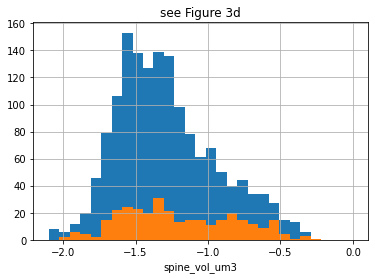

In [77]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
new_df.query('num_syn_in_conn==1')['log_spine_vol_um3'].hist(bins=np.linspace(-2.1,0,30))
new_df.query('num_syn_in_conn==2')['log_spine_vol_um3'].hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('spine_vol_um3')
ax.set_title('see Figure 3d')

Interestingly, it looks like the relative amount of smaller and larger spine heads is different between the two.

Does a dual synapse connection tend to have synapses that are either both small or both large?
To get a hint at this, we can plot the mean size within the connection, not just the size for each synapse.


Text(0.5, 1.0, 'see Figure 3e')

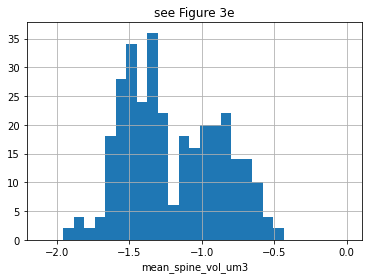

In [81]:
f, ax = plt.subplots()
new_df.query('num_syn_in_conn==2')['mean_log_spine_vol_um3'].hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('mean_spine_vol_um3')
ax.set_title('see Figure 3e')

You can see below that the results look interestingly bimodal, suggesting that there might be distinct characteristic sizes for synapses between layer 2/3 excitatory neurons: "large spines" and "small spines". See the preprint above for more analysis on this.

Finally, we can go back to JupyterDash to look at the table more dynamically.

In [82]:
selected_columns = ['num_syn_in_conn', 'mean_spine_vol_um3', 'cleft_vx', 'spine_vol_um3',
       'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm', 'log_spine_vol_um3', 'log_cleft_vx',
       'mean_cleft_vx', 'mean_log_spine_vol_um3', 'mean_log_cleft_vx']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

configure_app(app, new_df,
              link_func=visualize_synapses, link_name='Neuroglancer Link',
              plot_columns = selected_columns)

app.run_server(mode='jupyterlab')